In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble.forest import _generate_sample_indices
from sklearn.tree import DecisionTreeRegressor
import sklearn.cross_validation as xval

In [3]:
names = ["mpg","cyl","disp","hp","weight","accel","year","origin","name"]

In [4]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data", names=names, sep="\s+")

In [5]:
df["hp"] = pd.to_numeric(df["hp"], errors="coerce")
df = df.dropna()

In [6]:
df.shape

(392, 9)

In [7]:
y = df["mpg"].as_matrix()
X = df.drop(["mpg", "name"], axis=1).as_matrix()

In [8]:
X.shape

(392, 7)

In [9]:
X

array([[   8. ,  307. ,  130. , ...,   12. ,   70. ,    1. ],
       [   8. ,  350. ,  165. , ...,   11.5,   70. ,    1. ],
       [   8. ,  318. ,  150. , ...,   11. ,   70. ,    1. ],
       ..., 
       [   4. ,  135. ,   84. , ...,   11.6,   82. ,    1. ],
       [   4. ,  120. ,   79. , ...,   18.6,   82. ,    1. ],
       [   4. ,  119. ,   82. , ...,   19.4,   82. ,    1. ]])

(array([  27.,   95.,  120.,   44.,   19.,   47.,   13.,   14.,    5.,    8.]),
 array([  46. ,   64.4,   82.8,  101.2,  119.6,  138. ,  156.4,  174.8,
         193.2,  211.6,  230. ]),
 <a list of 10 Patch objects>)

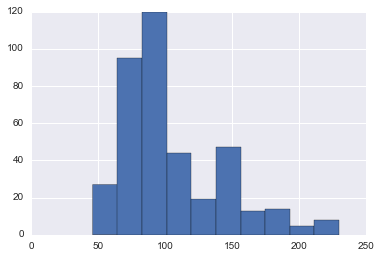

In [10]:
plt.hist(X[:, 2])

In [11]:
X_train, X_test, y_train, y_test = xval.train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
def calc_inbag(n_samples, forest):
    n_trees = forest.n_estimators
    inbag = np.zeros((n_samples, n_trees))
    for t_idx in range(n_trees):
        sample_idx = _generate_sample_indices(forest.estimators_[t_idx].random_state, 
                                              n_samples)
        inbag[:, t_idx] = np.bincount(sample_idx, minlength=n_samples)
    return inbag

In [13]:
n_trees = 2000

In [14]:
forest = RandomForestRegressor(n_estimators=n_trees)

In [15]:
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [16]:
inbag = calc_inbag(X_train.shape[0], forest)

In [17]:
def random_forest_error(forest, inbag, X_train, X_test):
    """ 
    forest : RandomForest{Regressor, Classifier}
    
    inbag : ndarray
        The inbag matrix (see `calc_inbag`) for the data with which this was fit
    
    X : ndarray
        with shape (n_sample, n_features).
    """
    pred = np.array([tree.predict(X_test) for tree in forest])
    pred_mean = np.mean(pred, 0)
    pred_centered = pred - pred_mean
    n_trees = forest.n_estimators
    n_train_samples = inbag.shape[0]

    cov_hat = np.zeros((X_train.shape[0], X_test.shape[0]))

    for t_idx in range(n_trees):
        cov_hat += np.dot((inbag[:, t_idx] - 1).reshape(-1, 1), pred_centered[t_idx].reshape(1, -1)) / n_trees

    V_IJ = np.sum(cov_hat ** 2, 0)
    V_IJ_unbiased = V_IJ - (X_train.shape[0] / (n_trees ** 2)) * np.sum(pred_centered ** 2, 0)
    return pred_mean, V_IJ_unbiased

In [18]:
y_hat, V_IJ_unbiased = random_forest_error(forest, inbag, X_train, X_test)

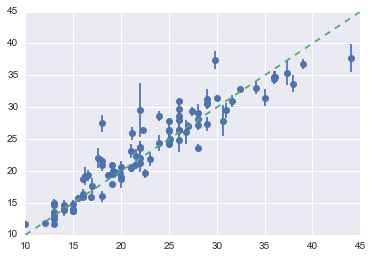

In [19]:
plt.errorbar(y_test, y_hat, yerr=np.sqrt(V_IJ_unbiased), fmt='o')
plt.plot([10, 45], [10, 45], '--')

(array([ 84.,   8.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  8.59143100e-03,   1.81864650e+00,   3.62870157e+00,
          5.43875663e+00,   7.24881170e+00,   9.05886677e+00,
          1.08689218e+01,   1.26789769e+01,   1.44890320e+01,
          1.62990870e+01,   1.81091421e+01]),
 <a list of 10 Patch objects>)

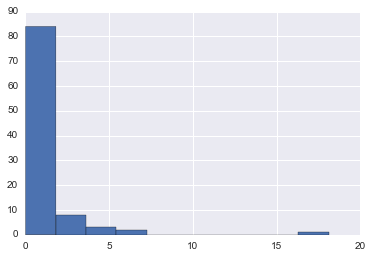

In [20]:
plt.hist(V_IJ_unbiased)

In [21]:
b = np.arange(10).reshape(10, 1)
c = np.arange(20).reshape((1, 20))